In [16]:
import zipfile
import pandas as pd
import datetime as dt
import numpy as np
import pytz
from scipy.signal import welch
from scipy.optimize import curve_fit
from scipy import stats
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.pyplot import cm
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,10
%matplotlib inline

In [17]:
def sp_to_dt(SD, SP, period_start=True):
    """
    Converts a settlement date and settlement period to a timezone-aware
    datetime object
    Parameters
    ----------
    SD : datetime.date object
        the settlement date
    SP : int
        the settlement period (in range 1 to 50)
    period_start : bool
        whether the desired datetime object should relate to the start (True)
        or end (False) of the settlement period
    Returns
    -------
    datetime : datetime.datetime
        a timezone-aware datetime object
    """
    #check date object passed - not datetime
    if not isinstance(SD, dt.date):
        raise ValueError('Expected Settlement Date parameter not of type datetime.date')

    #minimum SP value check
    if SP < 1:
        raise ValueError('SP value of %d less than minimum value of 1' % SP)

    #maximum SP value check, taking into account transition days
    transition_days = [dt.date(x.year, x.month, x.day)
                       for x in pytz.timezone('Europe/London')._utc_transition_times]
    if SD in transition_days[::2]: #clocks go forward
        if SP > 46:
            raise ValueError('SP value of %d exceeds maximum value of 46 \
                             for forward clock change date' % SP)
    elif SD in transition_days[1::2]: #clocks go back
        if SP > 50:
            raise ValueError('SP value of %d exceeds maximum value of 50 \
                             for backward clock change date' % SP)
    elif SP > 48:
        raise ValueError('SP value of {} exceeds maximum value of 48 for \
                         non-clock change date {}'.format(SP, SD))

    datetime = dt.datetime(SD.year, SD.month, SD.day, tzinfo=pytz.utc)
    datetime += dt.timedelta(minutes=(SP-1)*30)
    if not period_start:
        datetime += dt.timedelta(minutes=30)

    # DST shift should only be applied on days after transition day
    # (as does not impact calculation until SP resets to 1)
    if SD in transition_days[::2]:
        pass
    elif SD in transition_days[1::2] and SP > 2:
        datetime -= dt.timedelta(hours=1)
    else:
        datetime -= datetime.astimezone(pytz.timezone('Europe/London')).dst()
    return datetime

In [18]:
#detrending functions

#function to be fitted to annual data - 3 sinusoidal terms with base angular frequency of 1/2 hour and two harmonics
def annualTrend(t,a0,a1,a2,a3,c1,c2,c3):
    if type(t) is dt.datetime:
        t = (t-dt.datetime(t.year,1,1)).total_seconds()/3600  #convert datetime object into hours since start of year
    b1 = 2.0*np.pi/(24.0*365.0*2.0)
    b2 = 2.0*b1
    b3 = 3.0*b1
    return a0+a1*np.sin(b1*t+c1)+a2*np.sin(b2*t+c2)+a3*np.sin(b3*t+c3)
    
#function to be fitted to daily residuals - 2 sinusoidal terms with base angular frequency of 1/2 hour and single harmonic  
def diurnalTrend(t,a0,a1,a2,c1,c2):
    if type(t) is pd.Timestamp:
        t = t.hour
    b1 = 2.0*np.pi/(24.0*2.0)
    b2 = 2.0*b1
    return a0+a1*np.sin(b1*t+c1)+a2*np.sin(b2*t+c2)
    
#season definitions by month    
def getSeason(timestamp):
    if timestamp.month <=3:
        return 0
    elif timestamp.month <=6:
        return 1
    elif timestamp.month <=9:
        return 2
    return 3
    
#wrapper to allow diurnal value to be returned without separately calculating season    
def diurnalTrendWithSeason(t,coefficients):
    return diurnalTrend(t,*coefficients[getSeason(t)])
    
#wrapper to curve fitting function to return annual trend coefficients
def getAnnualCoefficients(timeseries):
    integerIndex=np.arange(len(timeseries))
    Apopt, Apcov = curve_fit(annualTrend, integerIndex, timeseries, p0=np.array([0.1,0.1,0.1,0.1,0.1,0.1,0.1]))
    return Apopt    
    
#wrapper to curve fitting function to return diurnal trend coefficients
def getDiurnalTrendCoefficients(timeseries):
    Dpopt, Dpcov = curve_fit(diurnalTrend, np.arange(24), timeseries, p0=np.array([0.1,0.1,0.1,0.1,0.1]))
    return Dpopt

In [19]:
#paths
GSP_data_path = '/users/graeme/Downloads/p114_gsp_data.zip'

In [20]:
#list all GSPs in a given GSP group area
GSP_area = 'N'
with zipfile.ZipFile(GSP_data_path) as z:
    with z.open('{}_gsp_data.csv'.format(GSP_area)) as f:
        raw_data = pd.read_csv(f)
        
raw_data['gsp_id'].unique()

array(['AYRR', 'BAIN', 'BROX', 'CAFA', 'CATY', 'CHAS', 'COAT', 'COCK',
       'CURR', 'DEVM', 'DEVO', 'DRCR', 'DRUM', 'DUMF', 'DUNB', 'ELDE',
       'GIFF', 'GLLE', 'GLLU', 'GLNI', 'GLRO', 'HAGR', 'HAWI', 'HELE',
       'HUER', 'KEOO', 'KILB', 'KILS', 'KILW', 'LEVE', 'PAIS', 'PART',
       'POOB', 'SACO', 'SANX', 'SHRU', 'SPAV', 'STIR', 'STLE', 'TONG',
       'WFIE', 'WGEO', 'WHHO', 'WISH', 'BAGA', 'BERW', 'BONN', 'BRAP',
       'CHAP', 'CLYM', 'COYL', 'CROO', 'CUMB', 'CUPA', 'DEWP', 'DUNF',
       'EAST', 'ECCL', 'EERH', 'EKIL', 'EKIS', 'ERSK', 'GALA', 'GORG',
       'GOVA', 'GRMO', 'INKE', 'JOHN', 'KAIM', 'KIER', 'KILT', 'LING',
       'LINM', 'MAYB', 'NEAR', 'NETS', 'PORD', 'RAVE', 'REDH', 'SIGH',
       'STHA', 'TELR', 'TOWH', 'ABNELVF', 'DFIN', 'KILN', 'DRYM', 'DALM3',
       'FINN'], dtype=object)

In [21]:
#GSPs and date range to select
#GSPs = ['A_ELST_1', 'P_MYBS_P', 'L_INDQ1', 'L_LAND1', 'L_ABHA1', 'L_EXET1']
GSPs = ['N_FINN', 'N_GOVA', 'N_PART', 'N_SANX', 'N_WGEO', 'N_CHAS', 'N_PORD', 'N_BRAP'] # Glasgow GSPs
start_date, end_date = dt.date(2009,1,1), dt.date(2019,1,1)

In [22]:
#extract raw data and collate into dataframe
#with half-hourly datetime index and each GSP as a column
raw_data_array = []
for GSP in GSPs:
    print(GSP)
    with zipfile.ZipFile(GSP_data_path) as z:
        with z.open('{}_gsp_data.csv'.format(GSP.split('_')[0])) as f:
            raw_data = pd.read_csv(f)
            gsp_data = raw_data[raw_data.gsp_id=='_'.join(GSP.split('_')[1:])][['settlement_date', 'settlement_period', 'meter_volume']]
            gsp_data['timestamp'] = gsp_data.apply(lambda row: sp_to_dt(dt.date(int(str(row['settlement_date'])[:4]),
                                                                                    int(str(row['settlement_date'])[4:6]),
                                                                                    int(str(row['settlement_date'])[6:8])),
                                                                        row['settlement_period'], 
                                                                        period_start=True), axis=1)
            trimmed_data = gsp_data[['timestamp', 'meter_volume']].set_index('timestamp').sort_index()[start_date:end_date]
            assert(len(trimmed_data) == (end_date-start_date)/dt.timedelta(minutes=30)+1) # check expected amount of data
            raw_data_array.append(list(trimmed_data['meter_volume'].values))

rawTimeSeries = pd.DataFrame(np.array(raw_data_array).T,
                             index = pd.DatetimeIndex(start=start_date,
                                                      end=end_date,
                                                      freq='30T'),
                             columns = GSPs)

rawTimeSeries.head()
    

N_FINN


ValueError: ('SP value of 47 exceeds maximum value of 46                              for forward clock change date', 'occurred at index 8930726')

In [26]:
gsp_data.loc[8930726]

settlement_date      20141026.0
settlement_period          47.0
meter_volume                0.0
Name: 8930726, dtype: float64

In [12]:
[dt.date(x.year, x.month, x.day) for x in pytz.timezone('Europe/London')._utc_transition_times]

[datetime.date(1, 1, 1),
 datetime.date(1901, 12, 13),
 datetime.date(1916, 5, 21),
 datetime.date(1916, 10, 1),
 datetime.date(1917, 4, 8),
 datetime.date(1917, 9, 17),
 datetime.date(1918, 3, 24),
 datetime.date(1918, 9, 30),
 datetime.date(1919, 3, 30),
 datetime.date(1919, 9, 29),
 datetime.date(1920, 3, 28),
 datetime.date(1920, 10, 25),
 datetime.date(1921, 4, 3),
 datetime.date(1921, 10, 3),
 datetime.date(1922, 3, 26),
 datetime.date(1922, 10, 8),
 datetime.date(1923, 4, 22),
 datetime.date(1923, 9, 16),
 datetime.date(1924, 4, 13),
 datetime.date(1924, 9, 21),
 datetime.date(1925, 4, 19),
 datetime.date(1925, 10, 4),
 datetime.date(1926, 4, 18),
 datetime.date(1926, 10, 3),
 datetime.date(1927, 4, 10),
 datetime.date(1927, 10, 2),
 datetime.date(1928, 4, 22),
 datetime.date(1928, 10, 7),
 datetime.date(1929, 4, 21),
 datetime.date(1929, 10, 6),
 datetime.date(1930, 4, 13),
 datetime.date(1930, 10, 5),
 datetime.date(1931, 4, 19),
 datetime.date(1931, 10, 4),
 datetime.date(193

In [71]:
#perform fitting of annual trend function, store coefficients in dataframe
print("Fitting annual trends...")
annualCoeffsDF = rawTimeSeries.apply(lambda x: pd.Series(getAnnualCoefficients(x)))
annualCoeffsDF.index = ['a0','a1','a2','a3','c1','c2','c3']
annualCoeffsDF

Fitting annual trends...


,A_ELST_1,P_MYBS_P,L_INDQ1,L_LAND1,L_ABHA1,L_EXET1
a0,127.549031,12.827673,110.414354,71.501641,71.529123,94.287520
a1,-20.993140,5.267726,24.883983,12.594280,14.547389,-19.341851
a2,6.120053,0.308728,4.262068,1.889121,-2.623683,-2.365272
a3,-3.332437,0.118213,2.654889,-1.111863,1.444451,-1.191317
c1,35.832445,58.231910,32.682731,26.421342,32.722531,29.542736
c2,7.658205,-1.080341,6.843488,0.767646,-2.574302,4.245939
c3,-3.650457,1.891266,-2.185514,1.786346,-1.727520,-5.576733


In [72]:
#create mirror of timeseries data with calculated annual components only
print("Generating annual components...")
annualComponentTimeSeries = pd.DataFrame(index=rawTimeSeries.index)
for column in annualCoeffsDF:
    columnData = pd.DataFrame([annualTrend(x,*annualCoeffsDF[column].values) 
                               for x in np.arange(len(rawTimeSeries.index+1))],
                              index=rawTimeSeries.index,
                              columns=['data'])
    annualComponentTimeSeries[column] = columnData.loc[:,['data']]
annualComponentTimeSeries.head()

Generating annual components...


,A_ELST_1,P_MYBS_P,L_INDQ1,L_LAND1,L_ABHA1,L_EXET1
2009-01-01 00:00:00,152.009616,17.901991,134.253555,83.823527,85.554860,114.091021
2009-01-01 00:30:00,152.015794,17.901843,134.257168,83.826016,85.557567,114.092873
2009-01-01 01:00:00,152.021969,17.901694,134.260778,83.828503,85.560272,114.094723
2009-01-01 01:30:00,152.028139,17.901545,134.264388,83.830989,85.562977,114.096570
2009-01-01 02:00:00,152.034306,17.901395,134.267995,83.833474,85.565680,114.098415


In [73]:
#create mirror of timeseries data with residuals (subtract annual components from raw time series data) 
print("Generating annual residuals...")
annualResiduals = rawTimeSeries.subtract(annualComponentTimeSeries)
annualResiduals.head()

Generating annual residuals...


,A_ELST_1,P_MYBS_P,L_INDQ1,L_LAND1,L_ABHA1,L_EXET1
2009-01-01 00:00:00,-20.209616,-13.016991,61.806445,16.186473,22.465140,15.068979
2009-01-01 00:30:00,-21.605794,-12.901843,65.002832,16.753984,23.722433,16.967127
2009-01-01 01:00:00,-24.071969,-12.941694,59.819222,14.131497,21.399728,12.565277
2009-01-01 01:30:00,-28.768139,-12.956545,48.875612,7.919011,17.217023,8.123430
2009-01-01 02:00:00,-34.064306,-13.261395,51.572005,9.136526,19.734320,11.341585


In [74]:
#get hourly averages by season for annual residuals
print("Fitting diurnal trends...")
hourlySeasonalAverages = annualResiduals.groupby([getSeason,
                                                  annualResiduals.index.map(lambda t: t.hour)]).mean()
hourlySeasonalAverages.head()

Fitting diurnal trends...


A_ELST_1  P_MYBS_P    L_INDQ1    L_LAND1    L_ABHA1    L_EXET1
0 0 -29.019732 -0.318025  21.495977  -6.165992  -3.101233   0.820090
  1 -34.061172 -0.094672  19.672651  -8.941588  -5.654975  -2.330378
  2 -39.255064 -0.119547  14.846236 -10.828267  -7.288041  -3.567249
  3 -43.539916 -0.565638   2.594835 -15.640374 -13.100940 -11.142144
  4 -46.596127  0.047825  -8.618945 -19.609078 -18.144637 -17.901225

In [75]:
#perform fitting of diurnal trend function, store coefficients in array
diurnalCoeffs = []
diurnalCoeffsDF = pd.DataFrame(index=['a0','a1','a2','c1','c2'])
for column in hourlySeasonalAverages.columns.values.tolist():
    nodeDiurnalCoeffs = []
    for season in hourlySeasonalAverages.index.levels[0]:
        Dpopt, Dpcov = curve_fit(diurnalTrend,
                                 np.arange(24),
                                 hourlySeasonalAverages.loc[season,:][column].values,
                                 p0=np.array([0.1,0.1,0.1,0.1,0.1]))
        nodeDiurnalCoeffs.append(Dpopt)
    diurnalCoeffs.append(nodeDiurnalCoeffs)
    diurnalCoeffsDF[column] = Dpopt
diurnalCoeffsDF

,A_ELST_1,P_MYBS_P,L_INDQ1,L_LAND1,L_ABHA1,L_EXET1
a0,-45.109588,1.115757,-59.964847,-28.697300,-25.781499,-30.476793
a1,71.630561,1.588234,-94.415030,44.427668,39.997701,47.132475
a2,-24.658182,0.392510,-46.548346,-16.013507,-15.806281,-19.106969
c1,-37.766198,-2.935508,-21.784834,-25.063880,-6.186030,-25.000584
c2,-31.756372,4.222248,-0.868007,-31.888437,-6.710642,-38.192453


In [76]:
print("Generating diurnal components...")   
#create mirror of timeseries data with calculated diurnal components only
diurnalComponentTimeSeries = pd.DataFrame(index=rawTimeSeries.index)
for column,coefficients in zip(rawTimeSeries.columns.values.tolist(),
                               diurnalCoeffs):
    columnData = pd.DataFrame([diurnalTrendWithSeason(x,coefficients) for x in rawTimeSeries.index],
                              index=rawTimeSeries.index,
                              columns=['data'])
    diurnalComponentTimeSeries[column] = columnData.loc[:,['data']]
diurnalComponentTimeSeries.head()

Generating diurnal components...


,A_ELST_1,P_MYBS_P,L_INDQ1,L_LAND1,L_ABHA1,L_EXET1
2009-01-01 00:00:00,-40.477697,-0.197712,14.188084,-11.979293,-8.019935,-4.684409
2009-01-01 00:30:00,-40.477697,-0.197712,14.188084,-11.979293,-8.019935,-4.684409
2009-01-01 01:00:00,-38.532660,-0.244573,15.751988,-11.201917,-7.913073,-4.627821
2009-01-01 01:30:00,-38.532660,-0.244573,15.751988,-11.201917,-7.913073,-4.627821
2009-01-01 02:00:00,-36.576727,-0.262850,14.472071,-10.772313,-8.163168,-5.166299


In [77]:
print("Generating diurnal residuals...")
#create mirror of timeseries data with both annual and diurnal components removed    
detrendedTimeSeries = annualResiduals.subtract(diurnalComponentTimeSeries)
detrendedTimeSeries.head()

Generating diurnal residuals...


,A_ELST_1,P_MYBS_P,L_INDQ1,L_LAND1,L_ABHA1,L_EXET1
2009-01-01 00:00:00,20.268081,-12.819279,47.618361,28.165766,30.485075,19.753388
2009-01-01 00:30:00,18.871902,-12.704131,50.814749,28.733278,31.742368,21.651536
2009-01-01 01:00:00,14.460691,-12.697121,44.067233,25.333415,29.312801,17.193098
2009-01-01 01:30:00,9.764520,-12.711972,33.123624,19.120929,25.130096,12.751251
2009-01-01 02:00:00,2.512421,-12.998545,37.099933,19.908839,27.897487,16.507884


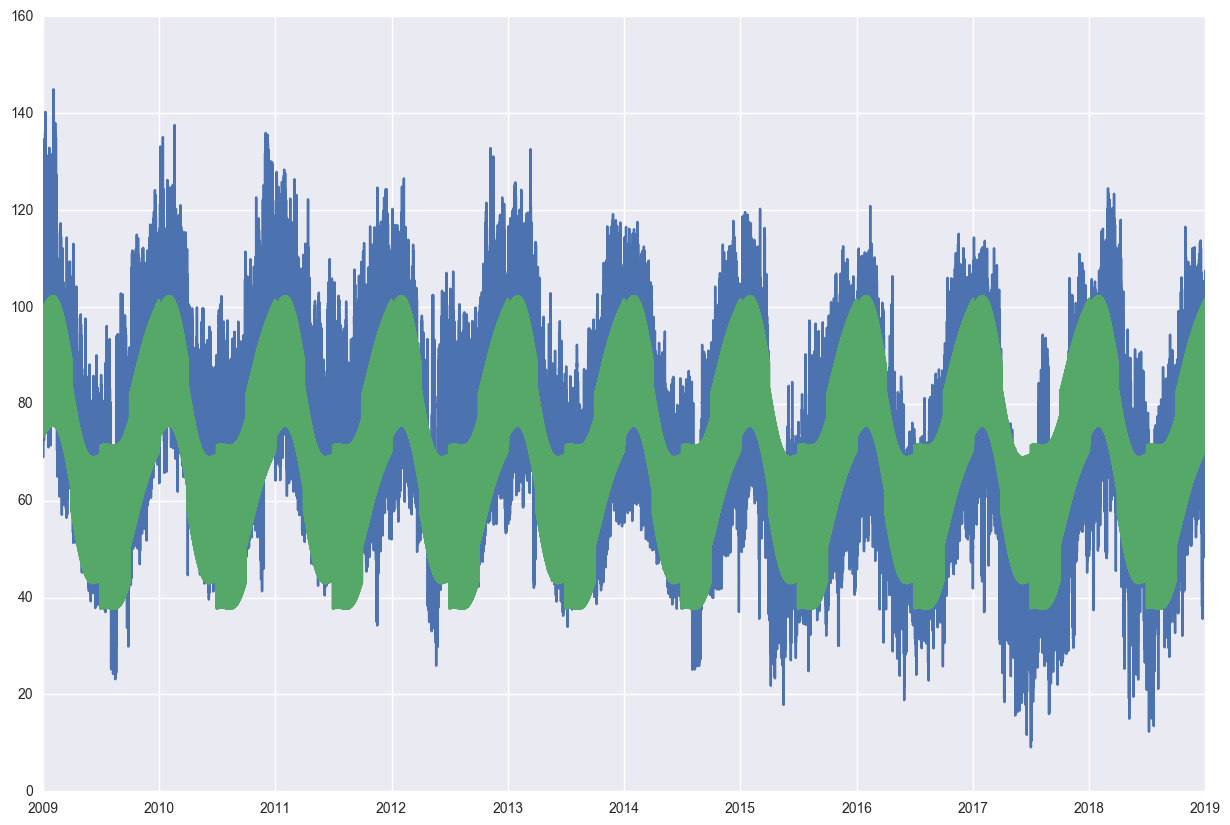

In [97]:
#show plots for chosen GSP
GSP = 'L_ABHA1'
ax = rawTimeSeries[GSP].plot() #raw data
(annualComponentTimeSeries[GSP]+diurnalComponentTimeSeries[GSP]).plot(ax=ax) #annual plus diurnal components

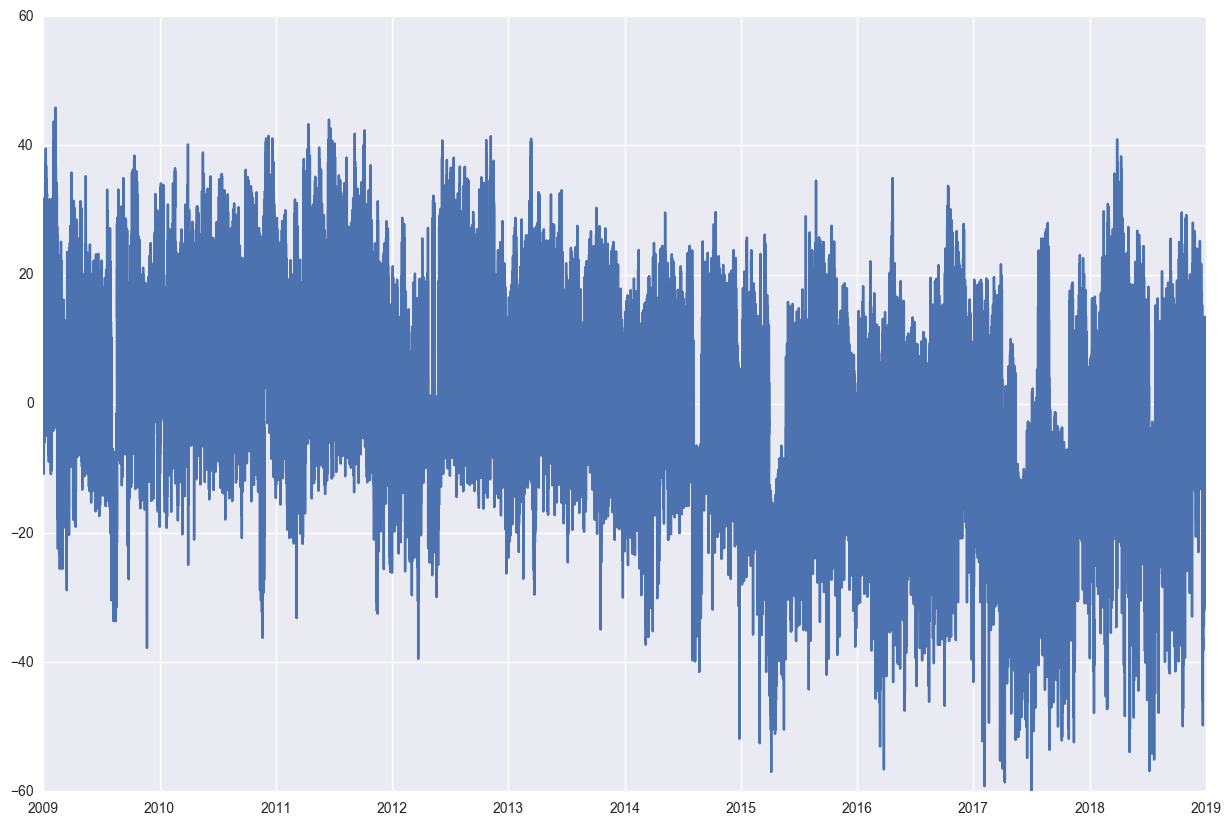

In [98]:
detrendedTimeSeries[GSP].plot() #what's left after annual and diurnal trends are removed

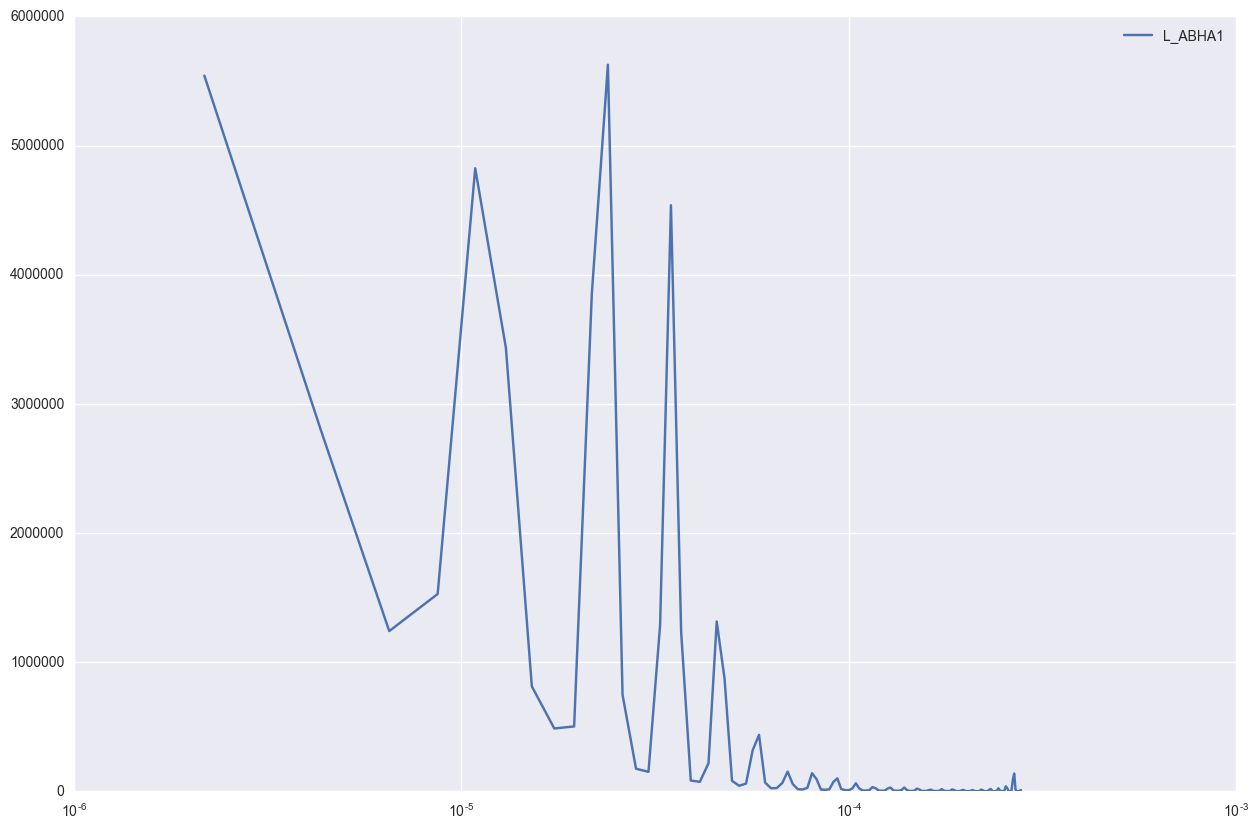

In [99]:
#look at power spectrum of residuals
f, psd = welch(detrendedTimeSeries[GSP].values,
               fs = 1/1800.0,
               window = 'hanning',
               detrend = 'constant')
plt.semilogx(f, psd, label=GSP)
plt.legend()

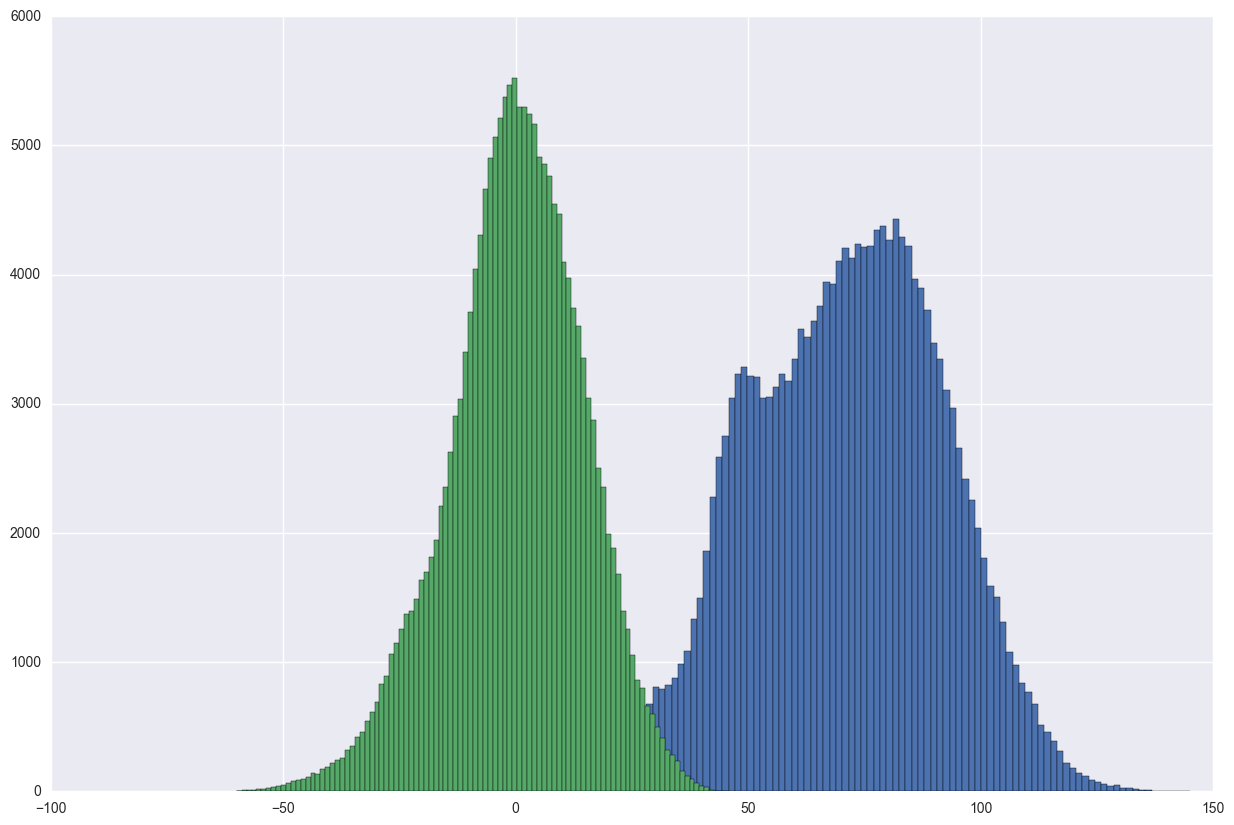

In [100]:
#look at distribution of raw vs detrended data
ax = rawTimeSeries[GSP].hist(bins=100)
detrendedTimeSeries[GSP].hist(bins=100, ax=ax)

In [101]:
#test if detrended data is normal - if p-value is less than critical value (e.g. 0.05)
k2, p = stats.normaltest(detrendedTimeSeries[GSP])
p

0.0

In [ ]:
#test if detrended data is stationary 
#https://machinelearningmastery.com/time-series-data-stationary-python/
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))